# Interactive plotting

This is a notebook containing an interactive 2D plot of the surface density.

You will need to have jupyter widgets to have interactivity in the notebook.

Alternatively, you can save the notebook to a file and run it as a python script.

In [1]:
import os
import numpy as np
import astropy
import astropy.units as u
from disgrid import Data
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.colors as mplcolors
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(level="INFO")

In [2]:
ds = Data("gapdepth/output/out_M1.0e-03")
avail = ds.avail()
Nfirst = avail["Nfirst"]
Nlast = avail["Nlast"]

In [3]:
def plot_planet_position(ax, data, inds, tref, rotate=0):
    """ Mark the position of a planet in a 2d plot.
        
    Parameters
    ----------       
    ax: pyplot.axes
        Axes object to plot the data onto.   
    data: simdata.Data
        Data object to get the planet data from.
    inds: list of int
        Indices of the planets.
    tref: astropy.units.Quantity("timelike")
        Time for which to mark the planets' location.
    """
    
    newlines = []
    for k, n in enumerate(inds):
        planet = data.planets[n]
        a = planet.get("semi-major axis").get_closest_to_time(tref).to_value("au")
        e = planet.get("eccentricity").get_closest_to_time(tref).value
        omega = planet.get("pericenter angle").get_closest_to_time(tref).value
        x = planet.get("x").get_closest_to_time(tref).to_value('au')
        y = planet.get("y").get_closest_to_time(tref).to_value('au')
        m = planet.get("mass").get_closest_to_time(tref).to_value("solMass")

        # t = data.get(var="semi-major axis", planet=n).time
        # narg = np.argmin(np.abs(t - tref))
        # a = data.get(var="semi-major axis", planet=n).data.to_value("au")[narg]
        # e = data.get(var="eccentricity", planet=n).data[narg].value
        # omega = data.get(var="pericenter angle", planet=n).data[narg].value
        # x = data.get(var="x", planet=n).data[narg].to_value('au')
        # y = data.get(var="y", planet=n).data[narg].to_value('au')
        # m = data.get(var="mass", planet=n).data[narg].to_value("solMass")

        plot_orbit(ax, a, e, omega, x, y, mass=m, rotate=rotate, plotid=f"plsys_{n}")
        

def plot_orbit(ax, a, e, omega, x, y, rotate=0, geometry="cartesian", lf=1, mass=None, plotid="plsys"):
    """ Plot a Keplerian orbit onto a 2d plot. 
    
    Parameters
    ----------
    ax: pyplot.axes
        Axes to plot on.
    a: float
        Semi-major axis of the orbit.
    e: float
        Eccentricity of the orbit.
    omega: float
        Pericenter angle of the orbit in radians.
    x: float
        X coordinate of the planet in au.
    y: float
        Y coordinate of the planet in au.
    rotate: float (optional)
        Angle to rotate the orbit plot by in radians.
    geometry: str (optional)
        Geometry of the plot, either 'cartesian' (default) or 'polar'
    lf: ? (optional)
        ?
    mass: float (optional)
        Mass of the planet in solar masses. If this is specified, a circle indicating the Hill sphere is drawn.
    """

    phi = np.linspace(-np.pi, np.pi, 500)
    r = a*(1-e**2)/(1+e*np.cos(phi - (omega - rotate)))
    
    x_orbit = r*np.cos(phi)
    y_orbit = r*np.sin(phi)
    
    if geometry == "polar":
        x_orbit = r
        y_orbit = map_angles(phi)
        inds = sorted(range(len(y_orbit)), key=lambda n: y_orbit[n])
        x_orbit = r[inds]
        y_orbit = y_orbit[inds]
        
    # make a cross

    x_rot = x*np.cos(rotate) + y*np.sin(rotate)
    y_rot = -x*np.sin(rotate) + y*np.cos(rotate)
    
    if geometry == "polar":
        r = np.sqrt(x_rot**2 + y_rot**2)
        phi = np.arctan2(y_rot, x_rot)
        x = r
        y = map_angles(phi)
    else:
        x = x_rot
        y = y_rot

    planet_color = "white"
    
    if mass is not None:
        rhill = a * (mass/3)**(1/3)
        mask = np.sqrt((x_orbit-x)**2 + (y_orbit-y)**2) < rhill
        x_orbit[mask] = np.nan
        y_orbit[mask] = np.nan

        ax.plot(x_orbit*lf, y_orbit*lf, color=planet_color,
                markeredgecolor="black", markeredgewidth=1,
                alpha=0.7, linestyle=":", linewidth=0.75, plotid=plotid+"_orbit")
        
    if mass is not None:
        xhill = rhill*np.cos(phi) + x
        yhill = rhill*np.sin(phi) + y
        ax.plot(xhill*lf, yhill*lf, color=planet_color,
                markeredgecolor="black", markeredgewidth=0,
                alpha=0.7, linestyle="-", linewidth=0.75,
                plotid=plotid+"_planet")
    else:
        ax.plot(x*lf, y*lf, 'o', color=planet_color, linewidth=1, markersize=4, alpha=0.7,
                markeredgecolor=None,
                markeredgewidth=0.0,
                plotid=plotid+"_planet")


def map_angles(phi, phi_min=-np.pi):
    """ Map angles to the range [phi_min, phi_min + 2pi]

    Parameters
    ----------
    phi: float
        Angles to map.
    phi_min: float
        Lower bound.
    """
    phi_max = phi_min + 2*np.pi
    phi = phi % (2*np.pi)
    if isinstance(phi, np.ndarray):
        phi[phi > phi_max] -= 2*np.pi
    else:
        if phi > phi_max:
            phi -= 2*np.pi
    return phi


In [5]:
N = Nlast

sigma = ds.get(var="mass density", N=N, dim="2d")
ri = sigma.grid.get_interfaces("r").to_value("au")
phii = sigma.grid.get_interfaces("phi").to_value("rad")
Ri, PHIi = np.meshgrid(ri, phii, indexing="ij")
Xi = Ri*np.cos(PHIi)
Yi = Ri*np.sin(PHIi)
Z = sigma.data.to_value("g/cm2")
r_outer_thresh = 0
Zmax_outer = np.max(Z[ri[:-1] > r_outer_thresh])
Z = Z/Zmax_outer

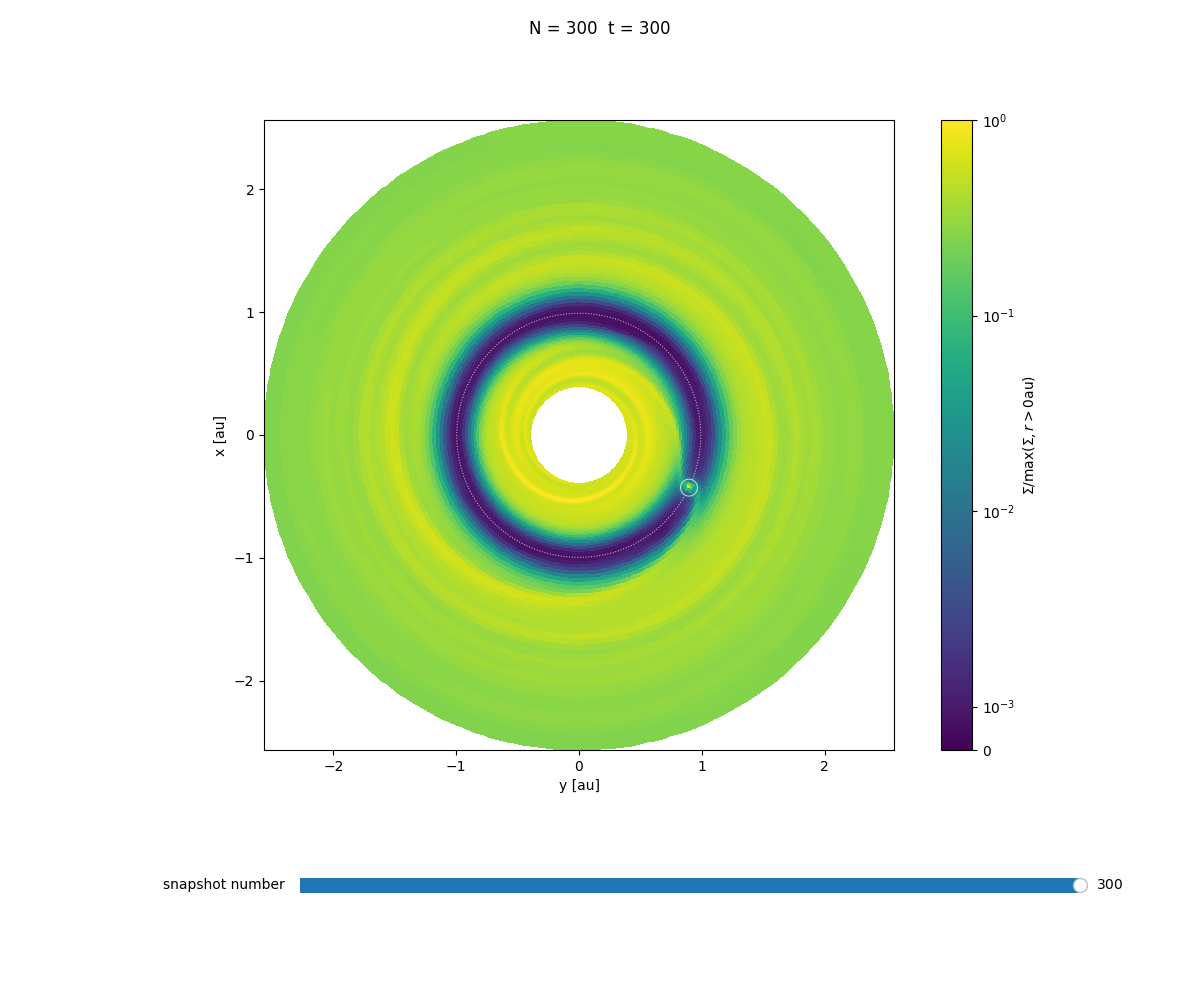

In [10]:
%matplotlib widget
from dataclasses import dataclass, field
from matplotlib.axes import Axes

@dataclass
class UpdateAxes:
    axes: Axes
    artists: dict = field(default_factory=dict)
    
    def plot(self, x, y, *args, plotid=None, **kwargs):
        try:
            artist = self.artists[plotid]
            artist.set_data(x,y)
            rv = (artist,)
        except KeyError:
            rv = self.axes.plot(x, y, *args, **kwargs)
            if plotid is not None:
                self.artists[plotid] = rv[0]
        return rv
        
    def pcolormesh(self, X, Y, Z, *args, plotid=None, update_grid=False, **kwargs):
        try:
            artist = self.artists[plotid]
            artist.set_array(Z.ravel())
            rv = artist
        except KeyError:
            rv = self.axes.pcolormesh(X, Y, Z, *args, **kwargs)
            if plotid is not None:
                self.artists[plotid] = rv
        return rv
                
    def __getattr__(self, name):
        return self.axes.__getattribute__(name)


# figures with two stacked axes
fig, ax = plt.subplots(ncols=1, nrows=1, sharex="all", figsize=(12,10))
uax = UpdateAxes(ax)


norm = mplcolors.SymLogNorm(linthresh=1e-3, linscale=0.2, vmin=0, vmax=1)

# store lines in array to update once slider moves

# initialize Sigma plot
pcm = uax.pcolormesh(Xi, Yi, Z, norm=norm, plotid="density")

ax.set_ylabel("x [au]")
ax.set_xlabel("y [au]")
ax.set_aspect("equal")

plot_planet_position(uax, ds, range(1,len(ds.planets)), sigma.time)


# add a colorbar
cax = fig.colorbar(pcm, ax=ax)
cax.set_label(r"$\Sigma/\mathrm{max}(\Sigma, r>" + f"{r_outer_thresh}" +r"\mathrm{au})$")

# display time
fig.suptitle(f"N = {N}  t = {sigma.time.to_value('yr'):.0f}")

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.25)

# Make a horizontal slider to control the frequency.
ax_snapshot = fig.add_axes([0.25, 0.1, 0.65, 0.03])
snapshot_slider = Slider(
    ax=ax_snapshot,
    label='snapshot number',
    valmin=Nfirst,
    valmax=Nlast,
    valinit=N
)

# The function to be called anytime a slider's value changes
def update(N=None):
    if N is None:
        N = int(snapshot_slider.val)
        snapshot_slider.val = N
    else:
        snapshot_slider.val = N
    # get new data
    sigma = ds.get(var="mass density", N=N, dim="2d")
    Z = sigma.data.to_value("g/cm2")
    Zmax_outer = np.max(Z[ri[:-1] > r_outer_thresh])
    Z = Z/Zmax_outer
    # set Sigma data
    # pcm.set_array(Z.ravel())
    uax.pcolormesh(Xi, Yi, Z, norm=norm, plotid="density")
    # update planet orbits
    plot_planet_position(uax, ds, range(1,len(ds.planets)), sigma.time)
    # display time
    fig.suptitle(f"N = {N:.0f}  t = {sigma.time.to_value('yr'):.0f} yr")
    fig.canvas.draw_idle()


# register the update function with each slider
snapshot_slider.on_changed(update)

def on_press(event):
    sval = int(snapshot_slider.val)
    if event.key == "left":
        N = sval - 1
    if event.key == "right":
        N = sval + 1
    update(N=N)
    

fig.canvas.mpl_connect('key_press_event', on_press)

plt.show()